In [ ]:
# mkdir data
# cd data
# wget https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip
# unzip vehicles.zip
# wget https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip
# unzip non-vehicles.zip
# https://github.com/udacity/self-driving-car/tree/master/annotations
# wget http://bit.ly/udacity-annotations-autti

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import sklearn

from glob import glob
#from sklearn.cross_validation import train_test_split
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from time import time

np.set_printoptions(threshold=np.nan)
#np.set_printoptions(threshold=10)

random.seed(0)

%matplotlib inline

In [2]:
# PREFIX_PATH = '/Users/tringuyen/OneDrive/Documents/2017 - Udacity Self Driving Car course/CarND-Vehicle-Detection/data/'
PREFIX_PATH = '/var/storage/shared/ipgsrch/trnguye/Google-Neural-Machine-Translation-GNMT-/tmp/CarND-Vehicle-Detection/data/'

PATH_TO_GTI_FAR_VEHICLES = \
    PREFIX_PATH + 'vehicles/GTI_Far/*.png'
PATH_TO_GTI_LEFT_VEHICLES = \
    PREFIX_PATH + 'vehicles/GTI_Left/*.png'
PATH_TO_GTI_CLOSE_VEHICLES = \
    PREFIX_PATH + 'vehicles/GTI_MiddleClose/*.png'
PATH_TO_GTI_RIGHT_VEHICLES = \
    PREFIX_PATH + 'vehicles/GTI_Right/*.png'
PATH_TO_KITTI_VEHICLES = \
    PREFIX_PATH + 'vehicles/KITTI*/*.png'
PATH_TO_GTI_NON_VEHICLES = \
    PREFIX_PATH + 'non-vehicles/GTI/*.png'
PATH_TO_KITTI_NON_VEHICLES = \
    PREFIX_PATH + 'non-vehicles/Extras/*.png'

In [3]:
MANUAL_SPLIT_VEHICLE_FILE_PATHS = [PATH_TO_GTI_FAR_VEHICLES, 
                                   PATH_TO_GTI_LEFT_VEHICLES, 
                                   PATH_TO_GTI_CLOSE_VEHICLES, 
                                   PATH_TO_GTI_RIGHT_VEHICLES]
RANDOM_SPLIT_VEHICLE_FILE_PATHS = [PATH_TO_KITTI_VEHICLES]
MANUAL_SPLIT_NON_VEHICLE_FILE_PATHS = [PATH_TO_GTI_NON_VEHICLES]
RANDOM_SPLIT_NON_VEHICLE_FILE_PATHS = [PATH_TO_KITTI_NON_VEHICLES]
TRAIN_DEV_TEST_SPLIT = (0.8, 0.1, 0.1)

In [4]:
def load_data(p_manual_split_file_paths, p_random_split_file_paths):
    output_train = []
    output_dev = []
    output_test = []

    if p_manual_split_file_paths is not None:
        for paths_to_file in p_manual_split_file_paths:
            paths_to_file = glob(paths_to_file)
            nb_files = len(paths_to_file)
            train, dev, test = \
                np.split(paths_to_file, 
                         [int(nb_files * TRAIN_DEV_TEST_SPLIT[0]), 
                          int(nb_files * (TRAIN_DEV_TEST_SPLIT[0] + TRAIN_DEV_TEST_SPLIT[1]))])
            output_train.append(train)
            output_dev.append(dev)
            output_test.append(test)
                
    for paths_to_file in p_random_split_file_paths:
        paths_to_file = glob(paths_to_file)
        train, dev_test = train_test_split(paths_to_file, train_size=TRAIN_DEV_TEST_SPLIT[0])
        dev, test = \
            train_test_split(
                dev_test,
                train_size=TRAIN_DEV_TEST_SPLIT[1] / (TRAIN_DEV_TEST_SPLIT[1] + TRAIN_DEV_TEST_SPLIT[2]))
        output_train.append(train)
        output_dev.append(dev)
        output_test.append(test)
    
    return np.concatenate(output_train), np.concatenate(output_dev), np.concatenate(output_test) 

In [5]:
def shuffle_image_paths(p_vehicle_image_file_paths, p_non_vehicle_image_file_paths):
    image_paths = np.concatenate((p_vehicle_image_file_paths, p_non_vehicle_image_file_paths))
    labels = np.concatenate((np.ones(len(p_vehicle_image_file_paths)), 
                             np.zeros(len(p_non_vehicle_image_file_paths))))
    image_paths, labels = shuffle(image_paths, labels)
    
    return image_paths, labels

In [6]:
def extract_features_from_single_image(
        p_image_file_path, 
        p_color_space='BRG', 
        p_resize=(64, 64),
        p_color_histogram_bin=32,
        p_color_histogram_bin_range=(0, 256),
        p_hog_orient=9, 
        p_hog_pix_per_cell=8, 
        p_hog_cell_per_block=2,
        p_feature_types=['bin spacial', 'histogram', 'hog']):

    image = cv2.imread(p_image_file_path)

    if p_color_space == 'HSV':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    elif p_color_space == 'LUV':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
    elif p_color_space == 'HLS':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    elif p_color_space == 'YUV':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    elif p_color_space == 'YCrCb':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)     

    image = cv2.resize(image, p_resize)
        
    features = np.array([])
    if 'bin spacial' in p_feature_types:
        bin_spatial_features = image.ravel()
        features = np.concatenate((features, bin_spatial_features))
    
    if 'histogram' in p_feature_types:
        color_histograms = []
        for channel in range(image.shape[2]):
            color_histograms.append(np.histogram(image[:, :, channel], 
                                                 bins=p_color_histogram_bin, 
                                                 range=p_color_histogram_bin_range)[0])
        features = np.concatenate((features, np.ravel(color_histograms)))

    if 'hog' in p_feature_types:
        hog_features = []
        for channel in range(image.shape[2]):
            hog_features.append(
                hog(image[:, :, channel],
                    orientations=p_hog_orient,
                    pixels_per_cell=(p_hog_pix_per_cell, p_hog_pix_per_cell),
                    cells_per_block=(p_hog_cell_per_block, p_hog_cell_per_block),
                    transform_sqrt=True,
                    visualise=False,
                    block_norm='L1'))
        features = np.concatenate((features, np.ravel(hog_features)))

    return features

In [7]:
def extract_features_from_file_paths(p_image_file_paths):
    features = []
    
    for image_file_path in p_image_file_paths:
        features.append(extract_features_from_single_image(image_file_path))

    features = np.vstack(features)
    
    return features

In [8]:
def train_classifier(verbal=True):            
    train_vehicles_file_paths, dev_vehicles_file_paths, test_vehicles_file_paths = \
        load_data(p_manual_split_file_paths=MANUAL_SPLIT_VEHICLE_FILE_PATHS, 
                  p_random_split_file_paths=RANDOM_SPLIT_VEHICLE_FILE_PATHS)
    train_non_vehicles_file_paths, dev_non_vehicles_file_paths, test_non_vehicles_file_paths = \
        load_data(p_manual_split_file_paths=MANUAL_SPLIT_NON_VEHICLE_FILE_PATHS, 
                  p_random_split_file_paths=RANDOM_SPLIT_NON_VEHICLE_FILE_PATHS)
        
    train_image_file_paths, train_labels = \
        shuffle_image_paths(train_vehicles_file_paths, train_non_vehicles_file_paths)
    dev_image_file_paths, dev_labels = \
        shuffle_image_paths(dev_vehicles_file_paths, dev_non_vehicles_file_paths)
    test_image_file_paths, test_labels = \
        shuffle_image_paths(test_vehicles_file_paths, test_non_vehicles_file_paths)
    
    if verbal:
        start_time = time()
    train_features = extract_features_from_file_paths(train_image_file_paths)
    dev_features = extract_features_from_file_paths(dev_image_file_paths)
    test_features = extract_features_from_file_paths(test_image_file_paths)
    
    all_features = np.concatenate((train_features, dev_features, test_features)).astype(np.float64)                        
    feature_scaler = StandardScaler().fit(all_features)
    train_scaled_features = feature_scaler.transform(train_features)
    dev_scaled_features = feature_scaler.transform(dev_features)
    test_scaled_features = feature_scaler.transform(test_features)
    if verbal:
        print('Extract features in %d seconds' % (time() - start_time))
    
    if verbal:
        start_time = time()
    classifier = SVC()

    # n_estimators = 10
    # classifier = BaggingClassifier(SVC(), max_samples=1.0 / n_estimators, n_estimators=n_estimators))

    # classifier = RandomForestClassifier(min_samples_leaf=20)
    classifier.fit(train_scaled_features, train_labels)
    if verbal:
        print('Train classifier in %d seconds' % (time() - start_time))

    if verbal:
        start_time = time()
        train_accuracy = classifier.score(train_scaled_features, train_labels)
        print()
        print('Train accuracy: %f' % train_accuracy)
        print('Evaluate train accuracy in %d seconds' % (time() - start_time))

        start_time = time()
        dev_accuracy = classifier.score(dev_scaled_features, dev_labels)
        print()
        print('Dev accuracy: %f' % dev_accuracy)
        print('Evaluate dev accuracy in %d seconds' % (time() - start_time))

        start_time = time()
        test_accuracy = classifier.score(test_scaled_features, test_labels)
        print()
        print('Test accuracy: %f' % test_accuracy)
        print('Evaluate test accuracy in %d seconds' % (time() - start_time))
        
        print()
        print('Sample predictions:')
        for i in range(10):
            random_num = random.randint(1, 10)
            image_file_path = test_image_file_paths[random_num]
            features = test_scaled_features[random_num].reshape(1, -1)
            label = test_labels[random_num]
            plt.figure()
            plt.imshow(cv2.imread(image_file_path)[:,:,::-1])
            plt.title('Label: %d ; Predict: %d' % (label, classifier.predict(features)))      
    
    return feature_scaler, classifier

/usr/local/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Extract features in 111 seconds
Train classifier in 836 seconds

Train accuracy: 0.998944
Evaluate train accuracy in 798 seconds

Dev accuracy: 0.993806
Evaluate dev accuracy in 103 seconds

Test accuracy: 0.992688
Evaluate test accuracy in 102 seconds

Sample predictions:


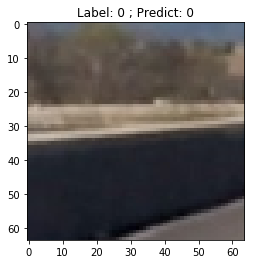

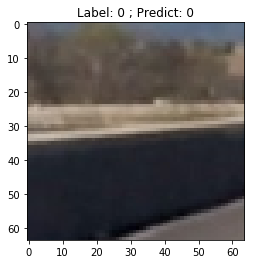

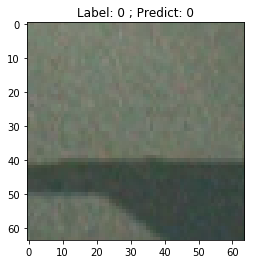

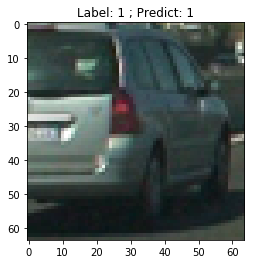

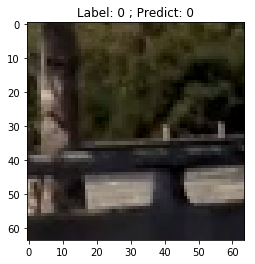

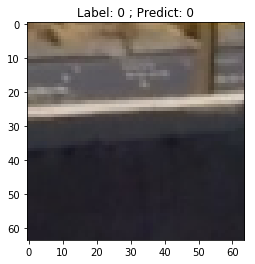

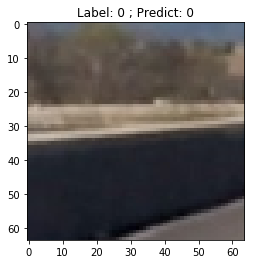

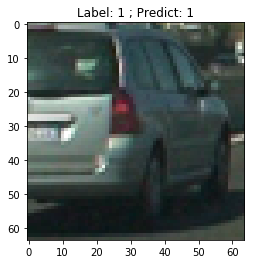

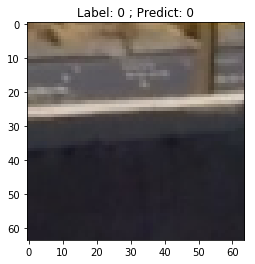

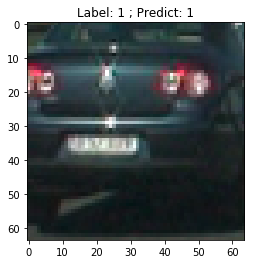

In [9]:
feature_scaler, classifier = train_classifier()

In [ ]:
def find_cars(
        p_imge, 
        p_y_span,
        p_image_window_size=(64, 64),
        p_feature_scaler,
    
        p_classifier,
        p_color_space='BRG',
        p_classifier_resize=(64, 64),
        p_classifier_color_histogram_bin=32,
        p_classifier_color_histogram_bin_range=(0, 256),
        p_classifier_hog_orient=9, 
        p_classifier_hog_pix_per_cell=8, 
        p_classifier_hog_cell_per_block=2,
        p_classifier_feature_types=['bin spacial', 'histogram', 'hog']):
    
    heatmap = np.zeros((p_image.shape[0], p_image.shape[1])
    
    search_area = p_image[p_y_span[0]:p_y_span[1],:,:]
    
    if p_color_space == 'HSV':
        search_area = cv2.cvtColor(search_area, cv2.COLOR_BGR2HSV)
    elif p_color_space == 'LUV':
        search_area = cv2.cvtColor(search_area, cv2.COLOR_BGR2LUV)
    elif p_color_space == 'HLS':
        search_area = cv2.cvtColor(search_area, cv2.COLOR_BGR2HLS)
    elif p_color_space == 'YUV':
        search_area = cv2.cvtColor(search_area, cv2.COLOR_BGR2YUV)
    elif p_color_space == 'YCrCb':
        search_area = cv2.cvtColor(search_area, cv2.COLOR_BGR2YCrCb)     
    
    search_area = cv2.resize(search_area, 
                             (np.int(search_area.shape[1] / p_image_window_size[1] * p_classifier_resize[1]), 
                              np.int(search_area.shape[0] / p_image_window_size[0] * p_classifier_resize[0])))

    nx_blocks = (search_area.shape[1] // p_classifier_hog_pix_per_cell) - p_classifier_hog_cell_per_block + 1
    ny_blocks = (search_area.shape[0] // p_classifier_hog_pix_per_cell) - p_classifier_hog_cell_per_block + 1
  
    nx_blocks_per_window = (p_image_window_size[1] // p_classifier_hog_pix_per_cell) - p_classifier_hog_cell_per_block + 1
    ny_blocks_per_window = (p_image_window_size[0] // p_classifier_hog_pix_per_cell) - p_classifier_hog_cell_per_block + 1

    nx_blocks_per_step = nx_blocks_per_window // 2
    ny_blocks_per_step = ny_blocks_per_window // 2

    nx_steps = (nx_blocks - nx_blocks_per_window) // nx_blocks_per_step
    ny_steps = (ny_blocks - ny_blocks_per_window) // ny_blocks_per_step

    hog_features = []
    for channel in range(search_area.shape[2]):
        hog_features.append(
            hog(search_area[:, :, channel],
                orientations=p_classifier_hog_orient,
                pixels_per_cell=(p_classifier_hog_pix_per_cell, p_classifier_hog_pix_per_cell),
                cells_per_block=(p_classifier_hog_cell_per_block, p_classifier_hog_cell_per_block),
                transform_sqrt=True,
                visualise=False,
                block_norm='L1',
                feature_vec=False))

    for xb in range(nx_steps):
        for yb in range(ny_steps):
            ypos = yb * ny_blocks_per_step
            xpos = xb * nx_blocks_per_step

            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img
    
ystart = 400
ystop = 656
scale = 1.5
    
out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

In [ ]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [ ]:
def slide_window(
    img, 
    x_start_stop=[None, None], 
    y_start_stop=[None, None], 
    xy_window=(64, 64), 
    xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    # Compute the span of the region to be searched    
    # Compute the number of pixels per step in x/y
    # Compute the number of windows in x/y
    # Initialize a list to append window positions to
    window_list = []

    img_size = (img.shape[1], img.shape[0])
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img_size[0]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img_size[1]
    pixels_per_step = (xy_window[0] * (1 - xy_overlap[0]), 
                       xy_window[1] * (1 - xy_overlap[1]))
    window_count = (int((x_start_stop[1] - x_start_stop[0] + 1) / pixels_per_step[0]),
                    int((y_start_stop[1] - y_start_stop[0] + 1) / pixels_per_step[1]))
                     
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
        # Calculate each window position
        # Append window position to list
    # Return the list of windows
    for x in range(window_count[0]):
        for y in range(window_count[1]):
            bottom_right = (int(x * pixels_per_step[0] + xy_window[0]),
                            int(y * pixels_per_step[1] + xy_window[1]))
            if (bottom_right[0] <= x_start_stop[1]) and \
               (bottom_right[1] <= y_start_stop[1]):
                window_list.append(((int(x * pixels_per_step[0]), 
                                     int(y * pixels_per_step[1])), 
                                    (bottom_right[0], 
                                     bottom_right[1])))
    return window_list

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], 
                                  window[0][0]:window[1][0]], (64, 64))
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
    
# Read in cars and notcars
images = glob.glob('*.jpeg')
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 500
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

image = mpimg.imread('bbox-example-image.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)


